In [ ]:
!pip install datasets


In [16]:
from datasets import load_dataset
import random

# Load the IMDB dataset
dataset = load_dataset("imdb")

# Combine training and testing datasets
all_data = dataset["train"].to_dict() | dataset["test"].to_dict()

# Shuffle the combined data
random.seed(42)
all_data = list(zip(all_data["text"], all_data["label"]))  # Convert to a list of (text, label) tuples
random.shuffle(all_data)

# Split into training and testing datasets
train_data = all_data[:2500]
test_data = all_data[2500:5000]

# Extract texts and labels
train_texts, train_labels = zip(*train_data)
test_texts, test_labels = zip(*test_data)

print(f"Training set size: {len(train_texts)}, Test set size: {len(test_texts)}")


Training set size: 2500, Test set size: 2500


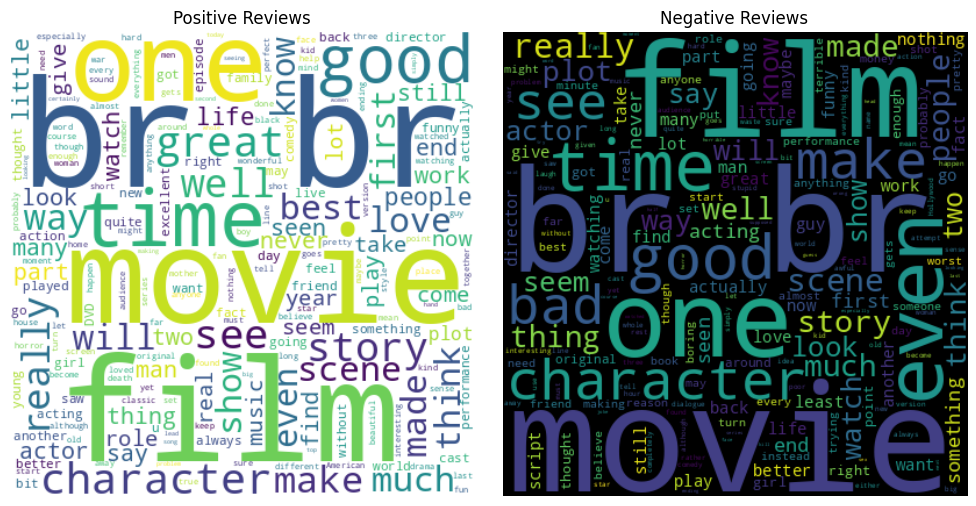

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate positive and negative reviews
all_positive = " ".join([text for text, label in train_data if label == 1])
all_negative = " ".join([text for text, label in train_data if label == 0])

# Plot word clouds
plt.figure(figsize=(10, 5))

# Positive reviews word cloud
plt.subplot(1, 2, 1)
plt.title("Positive Reviews")
positive_wordcloud = WordCloud(width=400, height=400, background_color="white").generate(all_positive)
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")

# Negative reviews word cloud
plt.subplot(1, 2, 2)
plt.title("Negative Reviews")
negative_wordcloud = WordCloud(width=400, height=400, background_color="black").generate(all_negative)
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")

plt.tight_layout()
plt.show()


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

print(f"Shape of training feature matrix: {X_train.shape}")


Shape of training feature matrix: (2500, 5000)


In [19]:
from sklearn.naive_bayes import MultinomialNB

# Train a Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train, train_labels)

# Evaluate the model
train_score = model.score(X_train, train_labels)
test_score = model.score(X_test, test_labels)
print(f"Training set accuracy: {train_score}")
print(f"Test set accuracy: {test_score}")


Training set accuracy: 0.9404
Test set accuracy: 0.8404


In [20]:
from sklearn.metrics import classification_report

# Generate classification report
predictions = model.predict(X_test)
report = classification_report(test_labels, predictions, target_names=["Negative", "Positive"])
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.87      0.85      1247
    Positive       0.86      0.81      0.84      1253

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500



In [22]:
from transformers import pipeline

# Load Hugging Face sentiment analysis model
sentiment_analyzer = pipeline("sentiment-analysis")

# Sample reviews for analysis
sample_texts = [
    "I absolutely loved this movie! The acting was brilliant.",
    "This was the worst film I have ever seen. Completely boring.",
    "The plot was okay, but the pacing was terrible.",
    "The best movie that I've never seen",
    "The worst movie that I've seen",
    "Not bad",
    "This is a good movie",
    "This is a bad movie"
]

# Perform sentiment analysis using Hugging Face
results = sentiment_analyzer(sample_texts)

# Print the results
for text, result in zip(sample_texts, results):
    print(f"Text: {text}\nResult: {result}\n")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Text: I absolutely loved this movie! The acting was brilliant.
Result: {'label': 'POSITIVE', 'score': 0.9998794794082642}

Text: This was the worst film I have ever seen. Completely boring.
Result: {'label': 'NEGATIVE', 'score': 0.9998098015785217}

Text: The plot was okay, but the pacing was terrible.
Result: {'label': 'NEGATIVE', 'score': 0.997711181640625}

Text: The best movie that I've never seen
Result: {'label': 'POSITIVE', 'score': 0.999864935874939}

Text: The worst movie that I've seen
Result: {'label': 'NEGATIVE', 'score': 0.9997757077217102}

Text: Not bad
Result: {'label': 'POSITIVE', 'score': 0.9995881915092468}

Text: This is a good movie
Result: {'label': 'POSITIVE', 'score': 0.9998646974563599}

Text: This is a bad movie
Result: {'label': 'NEGATIVE', 'score': 0.9997872710227966}



In [23]:
# Compare results between Naive Bayes and Hugging Face
naive_bayes_predictions = model.predict(vectorizer.transform(sample_texts))

print("\n=== Comparison Between Models ===")
for text, nb_result, hf_result in zip(sample_texts, naive_bayes_predictions, results):
    nb_label = "Positive" if nb_result == 1 else "Negative"
    hf_label = hf_result['label']
    print(f"Text: {text}")
    print(f"Naive Bayes Prediction: {nb_label}")
    print(f"Hugging Face Prediction: {hf_label}, Confidence: {hf_result['score']:.2f}\n")



=== Comparison Between Models ===
Text: I absolutely loved this movie! The acting was brilliant.
Naive Bayes Prediction: Positive
Hugging Face Prediction: POSITIVE, Confidence: 1.00

Text: This was the worst film I have ever seen. Completely boring.
Naive Bayes Prediction: Negative
Hugging Face Prediction: NEGATIVE, Confidence: 1.00

Text: The plot was okay, but the pacing was terrible.
Naive Bayes Prediction: Negative
Hugging Face Prediction: NEGATIVE, Confidence: 1.00

Text: The best movie that I've never seen
Naive Bayes Prediction: Positive
Hugging Face Prediction: POSITIVE, Confidence: 1.00

Text: The worst movie that I've seen
Naive Bayes Prediction: Negative
Hugging Face Prediction: NEGATIVE, Confidence: 1.00

Text: Not bad
Naive Bayes Prediction: Negative
Hugging Face Prediction: POSITIVE, Confidence: 1.00

Text: This is a good movie
Naive Bayes Prediction: Negative
Hugging Face Prediction: POSITIVE, Confidence: 1.00

Text: This is a bad movie
Naive Bayes Prediction: Negative


In [27]:
# Truncate the text to a maximum token length of 512
def truncate_text(text, max_length=512):
    return text[:max_length]

# Apply truncation to the test dataset
truncated_test_texts = [truncate_text(text, max_length=512) for text in test_texts]

# Perform sentiment analysis on truncated texts
hf_predictions = [sentiment_analyzer(text)[0]['label'] for text in truncated_test_texts]
hf_predictions = [1 if label == "POSITIVE" else 0 for label in hf_predictions]

# Evaluate Hugging Face model
hf_test_accuracy = accuracy_score(test_labels, hf_predictions)
print(f"Hugging Face Test Set Accuracy: {hf_test_accuracy}")

# Print classification report for Hugging Face
hf_report = classification_report(test_labels, hf_predictions, target_names=["Negative", "Positive"])
print("Hugging Face Classification Report:")
print(hf_report)


Hugging Face Test Set Accuracy: 0.8292
Hugging Face Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.85      0.83      1247
    Positive       0.85      0.80      0.83      1253

    accuracy                           0.83      2500
   macro avg       0.83      0.83      0.83      2500
weighted avg       0.83      0.83      0.83      2500

